# Decoder - KDLUN

In [1]:
import os
epochs = 20
batch = 2**8
dataset_folder = '/home/jovyan/share/Raiso/datasets'

# tapsize
ts = 10
# feature
feat_file = os.path.join(dataset_folder, 'B3D71_LFDAS_ALL.pickle') 
# target
tft_flie = os.path.join(dataset_folder, 'B3D71_DLC_HANDXY.npy') 

print('Batch ', batch)

Batch  256


In [2]:
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pickle
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cuda


In [3]:
feat = pickle.load(open(feat_file, 'rb'))
tgt = np.load(tft_flie)
tgt = tgt - tgt[0]

tdim = feat.shape[0]
idim, odim = feat.shape[1], tgt.shape[1]
print(tdim, idim, odim)

184000 38 2


In [4]:
class Dateset(torch.utils.data.Dataset):
    def __init__(self, feat, tgt, ts):
        print(feat.shape, tgt.shape)
        self.feat = torch.Tensor(feat)
        self.tgt = torch.Tensor(tgt)
        self.tdim = tgt.shape[0]

    def __getitem__(self, i):
        return self.feat[i:i+ts], self.tgt[i:i+ts-1], self.tgt[i+ts-1]

    def __len__(self):
        return self.tdim-ts+1

In [5]:
cut1 = int(0.7 * tdim)
cut2 = int(0.8 * tdim)

tr_set = Dateset(feat[:cut1], tgt[:cut1], ts)
dv_set = Dateset(feat[cut1:cut2], tgt[cut1:cut2], ts)
tt_set = Dateset(feat[cut2:], tgt[cut2:], ts)

del cut1, cut2
print('Shape: ', len(tr_set), len(dv_set), len(tt_set))

(128799, 38) (128799, 2)
(18401, 38) (18401, 2)
(36800, 38) (36800, 2)
Shape:  128790 18392 36791


In [6]:
tr_load = DataLoader(tr_set, batch, shuffle=True,
                    drop_last=False, pin_memory=True)  
dv_load = DataLoader(dv_set, batch, shuffle=False,
                    drop_last=False, pin_memory=True)  
tt_load = DataLoader(tt_set, batch, shuffle=False,
                    drop_last=False, pin_memory=True)  

In [7]:
class Decoder(nn.Module):
    def __init__(self, idim, odim, ts):
        super().__init__()
        self.gru1 = nn.GRU(idim, idim, num_layers=1, batch_first=True, bidirectional=True)
        self.gru2 = nn.GRU(2 * idim, 256, num_layers=1, batch_first=True, bidirectional=True)
        self.fc_yb = nn.Sequential(
            nn.Linear(odim * (ts-1), 16),
            nn.ReLU(),
        )
        self.fc_x = nn.Sequential(
            nn.Linear(256 * 2 * ts, 16),
            nn.ReLU(),
        )
        self.gate = nn.Sequential(
            nn.Linear(256 * 2 * ts, 16),
            nn.Sigmoid(),
        )
        self.readout = nn.Sequential(
            nn.Linear(16, 4),
            nn.ReLU(),
            nn.Linear(4, odim),  
        )
        self.criterion = nn.MSELoss()
    
    def forward(self, x, yb):
        bz, _, _ = x.size()
        x, _ = self.gru1(x)
        x = nn.functional.layer_norm(x, x.size()[-1:])
        x, _ = self.gru2(x)
        emb = nn.functional.layer_norm(x, x.size()[-1:])
        g = self.gate(emb.reshape(bz, -1))
        yyb = self.fc_yb(yb.reshape(bz, -1))
        yu = self.fc_x(emb.reshape(bz, -1))
        yh = self.readout(torch.mul(torch.add(g, -1),yyb) + torch.mul(yu,g))
        return yh
   
    def cal_loss(self, yh, y):
        return self.criterion(yh, y)

model = Decoder(idim, odim, ts).to(device)
print(model)

Decoder(
  (gru1): GRU(38, 38, batch_first=True, bidirectional=True)
  (gru2): GRU(76, 256, batch_first=True, bidirectional=True)
  (fc_yb): Sequential(
    (0): Linear(in_features=18, out_features=16, bias=True)
    (1): ReLU()
  )
  (fc_x): Sequential(
    (0): Linear(in_features=5120, out_features=16, bias=True)
    (1): ReLU()
  )
  (gate): Sequential(
    (0): Linear(in_features=5120, out_features=16, bias=True)
    (1): Sigmoid()
  )
  (readout): Sequential(
    (0): Linear(in_features=16, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=2, bias=True)
  )
  (criterion): MSELoss()
)


# Training

In [8]:
begin = time.time()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)
tr_loss = []
dv_loss = []
mini_dv_loss = 2e9

for e in tqdm(range(epochs)):
    model.train()
    for x, yb, y in tr_load:
        optimizer.zero_grad()
        x, yb, y = x.to(device), yb.to(device), y.to(device)
        yh = model(x, yb) 
        loss = model.cal_loss(yh, y)
        loss.backward()
        optimizer.step()
        tr_loss.append(loss.detach().cpu().item())

    model.eval() 
    ave_dv_loss = 0
    for x, yb, y in dv_load:
        x, yb, y = x.to(device), yb.to(device), y.to(device)
        with torch.no_grad():
            yh = model(x, yb) 
            loss = model.cal_loss(yh, y)
        ave_dv_loss += loss.detach().cpu().item() * len(x)  # accumulate loss
    ave_dv_loss = ave_dv_loss / len(dv_load.dataset)
    dv_loss.append(ave_dv_loss)
    
    if ave_dv_loss < mini_dv_loss:
        mini_dv_loss = ave_dv_loss
        # print('Saving model (epoch = {:4d}, loss = {:.4f})'.format(e + 1, ave_dv_loss))
        torch.save(model.state_dict(), 'best_model.pt')

print(f'time cost: {time.time() - begin}')

100%|██████████| 20/20 [00:56<00:00,  2.83s/it]

time cost: 56.54293990135193


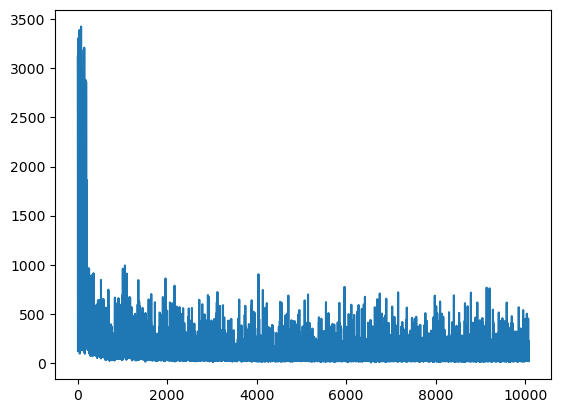

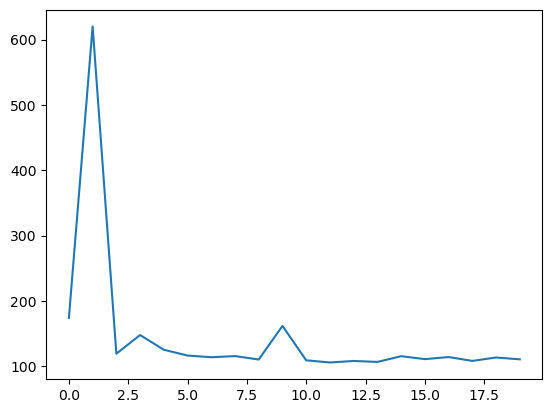

In [9]:
plt.plot(tr_loss)
plt.show()
plt.plot(dv_loss)
plt.show()

# Testing

In [10]:
del model
model = Decoder(idim, odim, ts).to(device)
ckpt = torch.load('best_model.pt', map_location='cpu')  # Load your best model
model.load_state_dict(ckpt)

<All keys matched successfully>

In [11]:
model.eval()               # set model to evalutation mode
pred, real = np.zeros((ts-1, odim)), np.zeros((ts-1, odim))
for x, _, y in tqdm(tt_load.dataset):                           # iterate through the dataloader
    x = torch.reshape(x, (1, x.shape[0], x.shape[1])).to(device)                        # move data to device (cpu/cuda)
    with torch.no_grad():                   # disable gradient calculation
        yb = torch.tensor(pred[-ts+1:], dtype=torch.float32)
        yb = torch.reshape(yb, (1, yb.shape[0], yb.shape[1])).to(device)
        yh = model(x, yb)                     # forward pass (compute output)
        pred = np.concatenate((pred, yh.detach().cpu().numpy()), axis=0)
    real = np.concatenate((real, y.detach().numpy().reshape(1,odim)))

100%|██████████| 36791/36791 [00:28<00:00, 1296.16it/s]


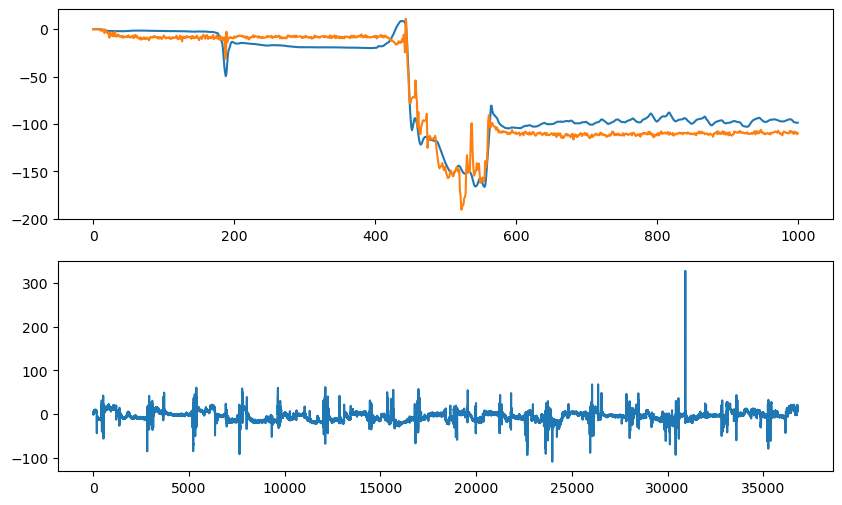

In [12]:
plt.figure(figsize = (10, 6))
plt.subplot(2,1,1)
plt.plot(pred[:1000,0])
plt.plot(real[:1000,0])
plt.subplot(2,1,2)
plt.plot(pred[:,0] - real[:,0])
plt.show()

In [13]:
r2 = r2_score(pred, real)
print(r2)

0.9128890670006742
